In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, cast, Date

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
the_most_recent_date_measurement_txt = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
the_most_recent_date_measurement = list(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
the_most_recent_date_measurement_str = str(the_most_recent_date_measurement)[2:-2]

the_most_recent_date_measurement_date=dt.datetime.strptime(the_most_recent_date_measurement_str, '%Y-%m-%d').date()
print(the_most_recent_date_measurement_date)

inspector = inspect(engine)
inspector.get_table_names()
for c in inspector.get_columns('station'):
    print(c['name'], c['type'])
for c in inspector.get_columns('measurement'):
    print(c['name'], c['type'])


2017-08-23
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


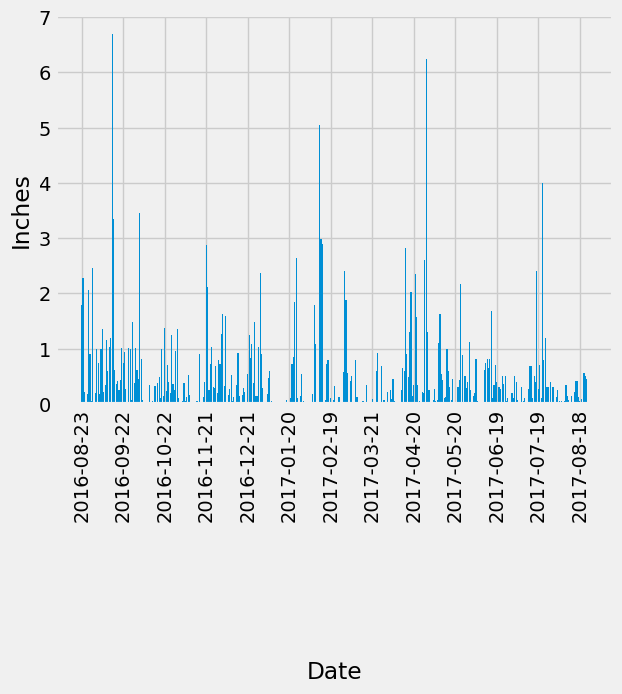

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year = the_most_recent_date_measurement_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(Measurement).\
    filter(Measurement.date >= last_year)

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_data_df = pd.read_sql(last_year_data.statement, last_year_data.session.bind)
last_year_data_df = last_year_data_df.drop(['id', 'station'], axis = 1)
last_year_data_df.set_index('date', inplace = True)
last_year_data_df

# Sort the dataframe by date
last_year_data_df.sort_index(inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(last_year_data_df.index, last_year_data_df.prcp)
plt.xlabel('Date', labelpad = 100)
plt.ylabel('Inches')
x_axis = last_year_data_df.index
plt.xticks(np.arange(0, 365, step=30), rotation = 90)
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_data_df['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
total_number_of_stations = session.query(Measurement.station).distinct().count()
print(total_number_of_stations)


9


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_names = session.query(Measurement.station).distinct()

station_number_of_readings = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

station_number_of_readings_df = pd.DataFrame(station_number_of_readings, columns = ['station', 'count'])
station_number_of_readings_df


,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
the_most_active_station = station_number_of_readings_df.loc[station_number_of_readings_df['count'].idxmax()]
the_most_active_station = the_most_active_station['station']

qry = session.query(func.max(Measurement.tobs).label('max_temp'), func.min(Measurement.tobs).label('min_temp'), func.avg(Measurement.tobs).label('avg_temp')).\
                    filter(Measurement.station == the_most_active_station)
res = qry.one()
max_temp = res.max_temp
min_temp = res.min_temp
avg_temp = res.avg_temp
print(max_temp)
print(min_temp)
print(avg_temp)


85.0
54.0
71.66378066378067


Text(0, 0.5, 'Inches')

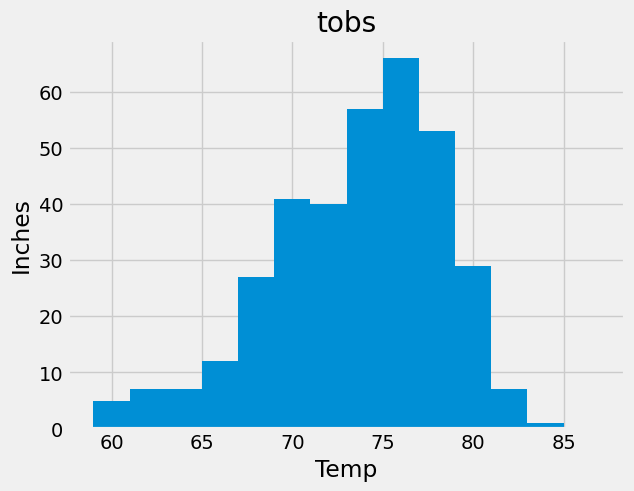

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
the_last_12_months_temp = session.query(Measurement.tobs).\
                            filter(Measurement.station == the_most_active_station).\
                            filter(Measurement.date >= last_year)

the_last_12_months_temp_df = pd.read_sql(the_last_12_months_temp.statement, the_last_12_months_temp.session.bind)
the_last_12_months_temp_df.head()
bins = np.arange(the_last_12_months_temp_df['tobs'].min(), the_last_12_months_temp_df['tobs'].max()+5, 2)
plt.hist(the_last_12_months_temp_df['tobs'], bins=bins, label='tobs')
plt.title('tobs')
plt.xlabel('Temp')
plt.ylabel('Inches')

# Close session

In [16]:
# Close Session
session.close()